**  Pridicting the Survived Passengers of the 1912 Titanic Disaster  **

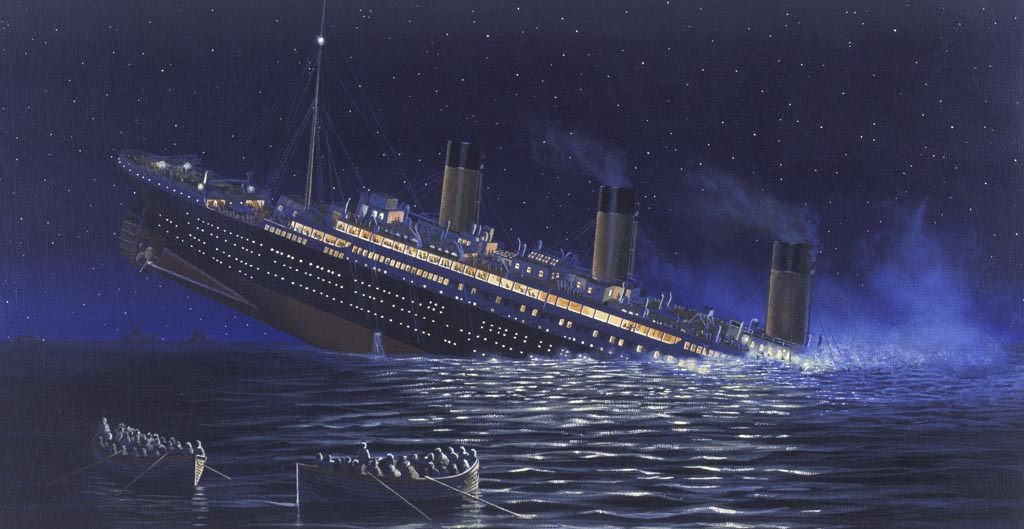

In [ ]:
import numpy as np
import pandas as pd 
import os
for dirnames, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirnames, filename))

In [ ]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

In [ ]:
train_data.head(5)

In [ ]:
train_data.info()

In [ ]:
train_data.describe()

In [ ]:
# lets see percentage of missing data
missing = (train_data.isnull().count() - train_data.count()) / train_data.isnull().count() * 100
missing = pd.DataFrame(data = { 'original': train_data.isnull().count() , 'missing' : train_data.isnull().count() - train_data.count(), '%' : missing})
missing.sort_values(by= '%', ascending = False).head(3)

In [ ]:
# Lets see Age distribution once
%matplotlib inline
import matplotlib.pyplot as plt
train_data['Age'].hist(bins= 40, figsize= (5, 5))
plt.show()

In [ ]:
# Lets try to explore the data wrt to Age and Sex a little bit
# but before that lets prepare some data for plotting

# finding the Age distribution of passengers who survived in Male and Female
women = train_data[train_data['Sex'] == 'female']
men = train_data[train_data['Sex'] == 'male']

Survived_women_Age_dist = women[women['Survived'] == 1].Age.dropna()
Survived_men_Age_dist = men[men['Survived'] == 1].Age.dropna()

# finding the Age distribution of passengers who died in Male and Female
Died_women_Age_dist = women[women['Survived'] == 0].Age.dropna()
Died_men_Age_dist = men[men['Survived'] == 0].Age.dropna()

In [ ]:
# Plot the data

import seaborn as sns
fig, axes = plt.subplots(nrows=1, ncols= 2, figsize = (10, 4))

ax = sns.distplot(Survived_men_Age_dist, bins = 40, label= 'Survived', ax = axes[0], kde= False)
ax = sns.distplot(Died_men_Age_dist, bins = 40, label = 'Not Survived', ax= axes[0], kde = False)
ax.legend()
ax.set_title('Male')

ax = sns.distplot(Survived_women_Age_dist, bins = 30, label= 'Survived', ax= axes[1], kde= False)
ax = sns.distplot(Died_women_Age_dist, bins= 30, label = 'Not Survived', ax= axes[1], kde= False)
ax.legend()
ax.set_title('Female')

In [ ]:
# inferences:
# 1. men tends to have higher survival rate when they are 20-35 years of age
# 2. females have higher survival rate alltogether than men
# 3. females among themselves have high survival rate 14-40(approx)
# 4. infants in both cases have higher probability of survival
# 5. men have low survival when they are above 45 or between 5-17(approx)
# IT LOOKS A GOOD IDEA TO CREATE A SEPERATE AGE GROUP FEATURE THUS SCALE THE DATA EVENLY.

In [ ]:
# Lets see how having number of relatives affects the survival rates, by adding it as a feature in a photocopy dataset.
train_copy = train_data.copy()
train_copy['relatives'] = train_data['SibSp'] + train_data['Parch']
axes = sns.factorplot('relatives','Survived', 
                      data=train_copy,kind= 'point' , aspect = 2 )

we see here passengers with 1-3 relatives had higher chances of surival but it droped down for people with more than 3(except 6)
passengers with 0 relative had only 30% of them survived.  

In [ ]:
#Lets see how many were people with 0 relatives and also check the same for 6 to see if they are significant in number and lucky as well.
train_copy['relatives'].value_counts()

Seems only handfull of people were there with 6 relatives, but a lot of people were traveling alone( 0 relatives) and out of which we see only around 30% of them survived. May be we could create a seperate feature of people traveling alone which decently affected their chances of survival. Let's keep this thing in mind for later and look at the correlation of each feature with the Survival rate using .corr() function.

In [ ]:
corr =  train_copy.corr()
corr['Survived'].sort_values(ascending = False)

In [ ]:
plot = train_data['Fare'].hist(bins = 20, label= 'Fare')
plot.legend()

Fare has a strong correlation with Survival rate, but it also has very uneven distribution
I want to create Fare groups of decent size but that would just distribute most of the Fares into few of the groups and rest groups would get very small number of Fares. We would look at a way to create an even distribution(buckets/groups) using great sklearn qcut() function after a little while. 
Passenger ID doesn't seems to be have much affect on survival.
Parch and Sibsp have both positive and negetive correlation respectively. Better did we combine them above already to get more closer picture.
We have already handles Age
Now let's look at Pclass which is also giving inverse correlation with Survival rate

In [ ]:
sns.factorplot('Pclass', 'Survived', data= train_data, kind=  'bar', aspect= 1.4)

In [ ]:
sns.factorplot('Embarked', 'Survived', data= train_data, kind=  'bar', aspect= 1.4)

we see class 1 has a higher chances of survival and a passenger with class 3 has fairly lower survival rate. That's an already clear distinction to be left the same way. So let's move forward.

DATA PREPROCESSING: Formation of custom transformers along with a data Pipeline that would perform our custom transformation along with some inbuilt preprocessing steps. 

In [ ]:
# Before doing any preprocessing to the data let's just keep an original copy of it separate.
train_original = train_data.copy()
train_data = train_data.drop(['Survived'], axis = 1)

In [ ]:
#lets have a look at the features before proceeding.
train_data.info()

In [ ]:
# Since we want to get the exact changes in our test set as well, so we will get ourself a custom transformer of our 
# own that we can call on test set as well later on. For now let's work on Training data.

from sklearn.base import BaseEstimator, TransformerMixin

class CustomTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, DoTransform= True):
        self.DoTransform = DoTransform
    def fit(self, X, y= None):
        return self
    def transform(self, X, y= None):
            if self.DoTransform == True:
                X['AgeBucket'] = (X['Age'] // 15 * 15).astype('Int64')
                X['relatives'] = X['SibSp'] + X['Parch']
                X['Not_Alone'] = X['relatives'].where(X['relatives'] == 0, 1)
                X.drop(['Age'], axis = 1, inplace= True)
                X['Fare'] = pd.qcut(X['Fare'], 6, labels = False)
                return X
            else:
                return X

# CustTran = CustomTransformer(DoTransform = True) 'Name', 'Ticket', 'Cabin',
# train_data_tr = CustTran.transform(train_data)
# train_data_tr

# Above Statements are just to check if our transformer is working fine , we will call its object in through our Pipeline.

we tried to pack everything in our transformer that cannot be using inbuilt classes. Now lets perform some transformations that can be handled by inbuilt classes such as handling the missing data and converting the categorical ones into numerical.

In [ ]:
# Lets seperately list out our numerical and categorical attributes first which we need and remove what we don't need.
train_num = train_data.drop(['Sex', 'Embarked', 'Name', 'Ticket', 'Cabin'], axis = 1)
num_attribs = list(train_num)
train_cat = train_data.drop(num_attribs, axis = 1)
train_cat = train_cat.drop(['Name', 'Ticket', 'Cabin'], axis = 1)
cat_attribs = list(train_cat)
print(cat_attribs)
print(num_attribs)
train_cat

In [ ]:
# Now lets create a pipeline that will run our transformers - both for numerical and categorical attributes
from sklearn.pipeline import Pipeline

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

num_pipeline = Pipeline([
    ('custom_tr', CustomTransformer(DoTransform = True)),
    ('impute', SimpleImputer(strategy= 'median')),
    ])

train_num_tr = num_pipeline.fit_transform(train_num)
train_num_tr[0:5, :]

# Above 2 lines of code are just to run the current cell to see if it's working fine. We will collectively run the whole 
# pipeline later

In [ ]:
cat_pipeline = Pipeline([
    ('Embarked', SimpleImputer(strategy= 'most_frequent')),
    ('cat_encode', OneHotEncoder(sparse = False)),
])
train_cat_tr =  cat_pipeline.fit_transform(train_cat)
train_cat_tr

In [ ]:
# # We wil finally run both pipelines here using ColumnTransformer by passing numerical and categorical part of the data
# whereever it's required
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
    ('num_transform', num_pipeline, num_attribs),
    ('cat_transform', cat_pipeline, cat_attribs),
    
])
final_train_data = full_pipeline.fit_transform(train_data)
final_train_data.shape

In [ ]:
# Now let's delete passengerID from the numerical data refering to its index using numpy.delete(arr, index, axis)
# We didn't delete it in our custom transformer because we will run the same for test data as well, and we need
# passengerID in the test set for submission to kaggle

X_train = np.delete(final_train_data, 0, 1) 
print(X_train.shape)
X_train[:5, :]


In [ ]:
# Get the labels for y_train
y_train = train_original['Survived']

In [ ]:
# I will be fitting the data to various machine learning models to see which performs good.
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
rfc = RandomForestClassifier(n_estimators=100, oob_score=True, random_state = 42)
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)

In [ ]:
dtc = DecisionTreeClassifier(random_state = 42)
dtc.fit(X_train, y_train)
dtc.score(X_train, y_train)

In [ ]:
svc = LinearSVC()
svc.fit(X_train, y_train)
svc.score(X_train, y_train)

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn.score(X_train, y_train)

In [ ]:
logr = LogisticRegression()
logr.fit(X_train, y_train)
logr.score(X_train, y_train)

In [ ]:
from sklearn.model_selection import cross_val_score as cvs
scores = cvs(rfc, X_train, y_train, cv = 4, scoring = 'accuracy')
print("Scores: ", scores)
print('Mean Score: ', scores.mean()) 
print("Std Dev: ", scores.std())

This looks pretty decent if not best, we have our best performing model a score of around over 80% with a standard deviation of 1%.

In [ ]:
# Lets look at the feature importance now that how each feature affect our model
featureImportance = rfc.feature_importances_
featureImportance = pd.DataFrame({'Features' : ['Pclass', 'SibSp', 'Parch', 'Fare', 'AgeBucket', 'Relatives', 
                                               'Not_Alone', 'Female', 'Male', 'C', 'Q', 'S'],
                                 'Importance' : featureImportance}).sort_values(by = 'Importance', ascending = False)
featureImportance

In [ ]:
featureImportance.plot.bar()

In [ ]:
# we see that 'C' , 'Q' and 'S' does not show to have any importance to the classifier. Also seems that Not Alone feature
# is quite useless as well. I may want to drop those features from my training set to see if predictions imporves.

In [ ]:
X_train = np.delete(X_train, [6, 9 ,10, 11], axis = 1)
X_train.shape


In [ ]:
#testing it on our classifier again
scores = cvs(rfc, X_train, y_train, cv = 10, scoring = 'accuracy')
print("Scores: ", scores)
print('Mean Score: ', scores.mean()) 
print("Std Dev: ", scores.std())

Well, that looks like an improvement! Now our model has over 82% accuracy with standard deviation of 3%.

Hyperparameter Tuning: using GridSearchCV

In [ ]:
param_grid = { "criterion" : ["gini", "entropy"], "min_samples_leaf" : [1, 5, 10, 25, 50, 70], "min_samples_split" : [2, 4, 10, 12, 16, 18, 25, 35], "n_estimators": [100, 400, 700, 1000, 1500]}
from sklearn.model_selection import GridSearchCV
gs_clf = GridSearchCV(estimator=rfc, param_grid=param_grid, n_jobs=-1)
gs_clf.fit(X_train, y_train)
gs_clf.best_params_

In [ ]:
final_model = gs_clf.best_estimator_

In [ ]:
from sklearn.externals import joblib
joblib.dump(final_model, 'final_model')

Now, We will run our pipeline on the test data: Remember, apart from the transformations done inside the pipeline we also did some transformations outside of the pipeline like deleting few Non Important features(based on their indices).
everything shall be repeated for the test data as well in order to successfully run it through our pipeline.
The no. of columns in our test data before running it through our saved pipeline should be exactly same as no. of columns there were in training data while it passed through the pipeline.

In [ ]:
Y_test = test_data.copy()
Y_test = full_pipeline.transform(test_data)
Y_test = np.delete(Y_test, [0, 6, 9 ,10, 11], axis = 1)
Y_test.shape

The submission according to compititon rules should be in csv format with exactly two cols: PassengerID of test set and our corresponding predictions. So I have just concatenated the PassengerID to my predictions and exported it as a new csv file for final submission.

In [ ]:
final_predictions = final_model.predict(Y_test)
final_predictions = pd.DataFrame({'PassengerId': test_data['PassengerId'], 'Survived': final_predictions})
joblib.dump(final_predictions, 'final_predictions')
final_predictions.to_csv(r'final_submission.csv', index = False)
joblib.dump(final_submission, 'final_submission')


In [ ]:
from IPython.display import FileLink
FileLink(r'final_submission.csv')

That's all Folks :)